In [1]:
import numpy as np
import pandas as pd
import os
import sys
import pickle
import time
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from ORAN_dataset import *

File config

In [2]:
# Notebook config
labels = {0: 'eMBB', 1: 'mMTC', 2: 'URLLc', 3: 'CTRL'}
font = {'size'   : 22}
matplotlib.rc('font', **font)
np.random.seed(42)

ds_pkl_path = "../logs/"
# Data file config
# Trial 7
ds_file = "SingleUE/dataset__emuc__Trial7__slice16_singleUE_raw_debug_CNTRL_trial7_raw__globalnorm.pkl"
norm_param_path = "../logs/global__cols_maxmin__debug_CNTRL_trial7_raw_slice16.pkl"
# Trial 1-6
#ds_file = "SingleUE/prev_experiments/dataset__emuc__Trial1_Trial2_Trial3_Trial4_Trial5_Trial6__slice16__globalnorm.pkl"
#norm_param_path = "../logs/SingleUE/prev_experiments/global__cols_maxmin__prevexp_globalnorm_slice16.pkl"
ds_path = "../"

T = int(norm_param_path.split('slice')[-1].split('.')[0])

In [3]:
args = {
    "ds_file": [ds_file],
    "isNorm": True,
    "ds_path": ds_pkl_path,
    "norm_param_path": norm_param_path,
    "relabel_train": False
}
    
print("--- Loading Train dataset without relabeling...")
# Not relabeled
ds_train_nr = ORANTracesDataset(args["ds_file"], key='train', normalize=args["isNorm"], sanitize=False, path=args["ds_path"], norm_par_path=args["norm_param_path"], relabel_CTRL=args["relabel_train"])
ds_info = ds_train_nr.info()
print(ds_info)
print("--- Loading Train dataset relabeling...")
# Relabeled
args['relabel_train'] = True
ds_train_rel = ORANTracesDataset(args["ds_file"], key='train', normalize=args["isNorm"], sanitize=False, path=args["ds_path"], norm_par_path=args["norm_param_path"], relabel_CTRL=args["relabel_train"])
ds_info = ds_train_rel.info()
print(ds_info)

--- Loading Train dataset without relabeling...
{'numfeats': 17, 'slice_len': 16, 'numsamps': 79715, 'nclasses': 4, 'samples_per_class': array([29073, 27829, 22376,   437])}
--- Loading Train dataset relabeling...
Initial # samps. per label (before relabeling)
	 Labels: [0 1 2 3] Count: [29073 27829 22376   437]
	Labels that contain norm < threshold [0 1 2 3] 
	Num of samples per label with norm < threshold: [10454 14624  8010   391]
Tot. samples relabeled (for every class): 33088
{'numfeats': 17, 'slice_len': 16, 'numsamps': 79715, 'nclasses': 4, 'samples_per_class': array([18619, 13205, 14366, 33525])}


In [4]:
# Check if X of datasets are the same 
df_rn = []
df_r = []
for i in range(len(ds_train_nr)):
    df_rn.append(ds_train_nr[i][0].flatten().numpy())
    df_r.append(ds_train_rel[i][0].flatten().numpy())
    
result = True
# Check if the lists are identical
for k in range(len(df_r)):
    if not (df_rn[k] == df_r[k]).all():
        result = False
        
# Print the result
print("The lists are identical:", result)

The lists are identical: True


In [5]:
N = 10000000
samples_per_class = [0, 0, 0, 0]
df_subset = []
df_classes_nr = []
df_classes_r = []

for i in range(len(ds_train_rel)):
    # If we have enough samples of that class do not add
    label_rel = ds_train_rel[i][1].item()
    label_nr = ds_train_nr[i][1].item()
    if samples_per_class[label_rel] < N:
        df_subset.append(ds_train_rel[i][0].flatten().numpy())
        df_classes_r.append(label_rel)
        samples_per_class[ds_train_rel[i][1].item()] += 1
        df_classes_nr.append(label_nr)
        

df_subset = np.array(df_subset)

In [6]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, learning_rate='auto',init='random', perplexity=50, n_iter=1000, random_state=1989)
tsne_results = tsne.fit_transform(df_subset)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 79715 samples in 0.013s...
[t-SNE] Computed neighbors for 79715 samples in 123.051s...
[t-SNE] Computed conditional probabilities for sample 1000 / 79715
[t-SNE] Computed conditional probabilities for sample 2000 / 79715
[t-SNE] Computed conditional probabilities for sample 3000 / 79715
[t-SNE] Computed conditional probabilities for sample 4000 / 79715
[t-SNE] Computed conditional probabilities for sample 5000 / 79715
[t-SNE] Computed conditional probabilities for sample 6000 / 79715
[t-SNE] Computed conditional probabilities for sample 7000 / 79715
[t-SNE] Computed conditional probabilities for sample 8000 / 79715
[t-SNE] Computed conditional probabilities for sample 9000 / 79715
[t-SNE] Computed conditional probabilities for sample 10000 / 79715
[t-SNE] Computed conditional probabilities for sample 11000 / 79715
[t-SNE] Computed conditional probabilities for sample 12000 / 79715
[t-SNE] Computed conditional probabilities for 

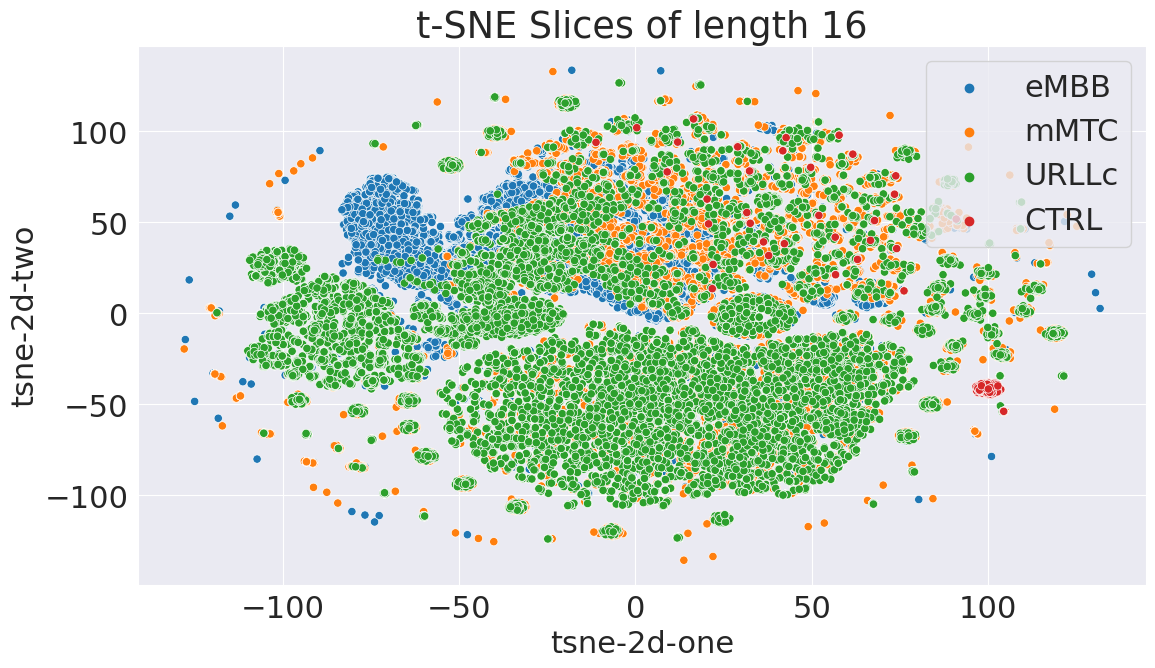

In [7]:
fig = plt.figure(figsize=(13,7))
df_plot = pd.DataFrame.from_dict({'tsne-2d-one': tsne_results[:,0], 'tsne-2d-two': tsne_results[:,1]})
df_plot['class'] = df_classes_nr
df_plot['Class'] = df_plot['class'].apply(lambda x: labels[x])
df_plot.sort_values(by=['class'], inplace=True)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='Class',
    hue_order = ['eMBB', 'mMTC', 'URLLc', 'CTRL'],
    palette=sns.color_palette("tab10", 4),
    data=df_plot,
    legend="full",
    alpha=1
).set(title=f't-SNE Slices of length {T}')
plt.legend(loc='upper right')
plt.savefig(f"../logs/SingleUE/prev_experiments/Before relabeling Slice {T}.png", transparent=True)

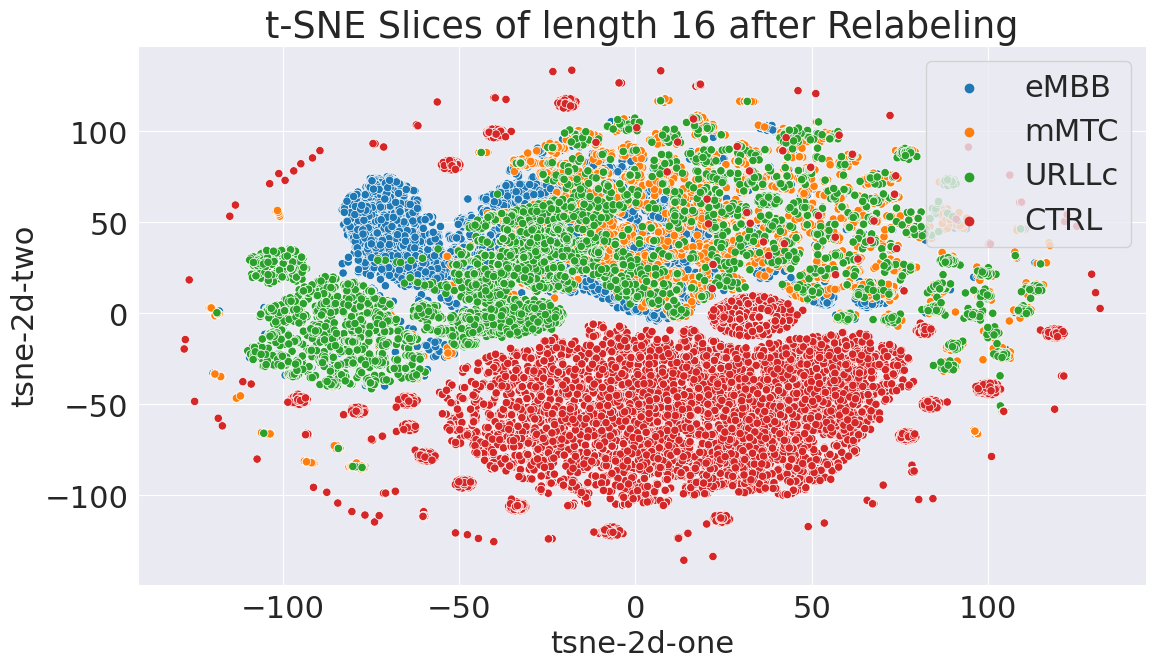

In [8]:
plt.figure(figsize=(13,7))
df_plot = pd.DataFrame.from_dict({'tsne-2d-one': tsne_results[:,0], 'tsne-2d-two': tsne_results[:,1]})
df_plot['class'] = df_classes_r
df_plot['Class'] = df_plot['class'].apply(lambda x: labels[x])
df_plot.sort_values(by=['class'], inplace=True)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='Class',
    hue_order = ['eMBB', 'mMTC', 'URLLc', 'CTRL'],
    palette=sns.color_palette("tab10", 4),
    data=df_plot,
    legend="full",
    alpha=1
).set(title=f't-SNE Slices of length {T} after Relabeling')
plt.legend(loc='upper right')
plt.savefig(f"../logs/SingleUE/prev_experiments/Relabeled Slice {T}.png", transparent=True)

In [9]:
df_subset.shape

(79715, 272)

In [10]:
df_subset_og_shape = df_subset.reshape((df_subset.shape[0],16,17))

# Visualization analysis
In this section we aim to visualize the features grouped in clusters by t-SNE algorithm. First, we show a (random) example of non-CTRL traffic.

Non-CTRL sample # 27286


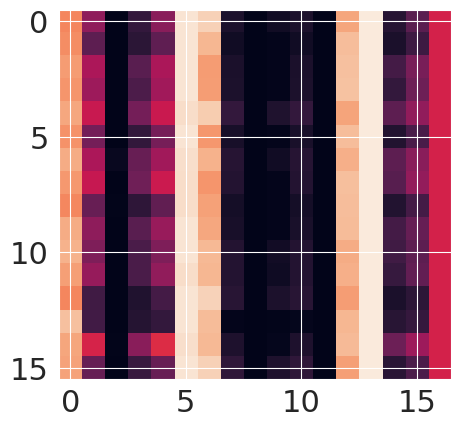

In [11]:
ix = np.random.choice(np.where(np.array(df_classes_r) != 3)[0])
print("Non-CTRL sample #", ix)
matplotlib.pyplot.imshow(df_subset_og_shape[ix])

Let's now take a closer look to the CTRL samples. Specifically, we want to visualize the samples in the large cluster in the bottom-right corner of t-SNE visualization output, in order to understand how features belonging to this cluster look like. The reason to do this is because we observe not only a sample similarity identified by t-SNE, but also it happens to contain a large number of samples relabeled as CTRL using the heuristic explained in the MEGATRON paper. 

We first obtain all the indexes of CTRL samples *after* relabeling procedure.

In [12]:
ctrl_after_relabel_ixs = np.where(np.array(df_classes_r) == 3)[0]

Then we randomly sample 30 of such CTRL samples and we plot only the ones that are contained in a rectangular area within the large cluster, specifically the ones that have coordinate $50 < x < 0$ and $0 > y > -50$ in the t-SNE visualization. Note that such boundaries should be chosen based on the visualization output, so they would need to be updated for a different run of t-SNE algorithm. 

From the plots below, we can see that samples in the rectangular area of interest within the cluster are indeed very similar to each other and they present almost identical features. Moreover, such features forms patterns that closely resembles the mean CTRL template used to relabel idle portions of traffic in other classes, demonstrating the validity of proposed relabeling approach. 

ORIGINAL LABEL: 1 COORDINATES [ 10.738387 -66.894966 ]


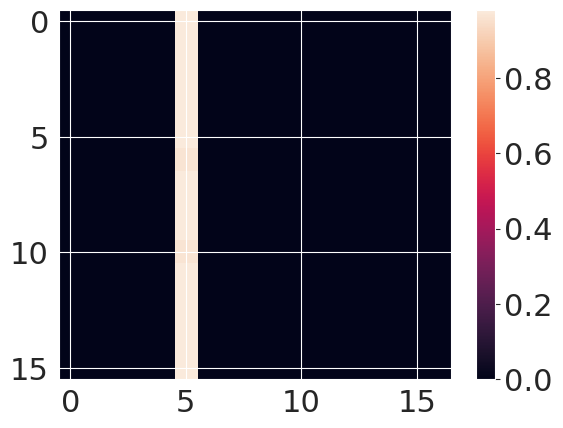

ORIGINAL LABEL: 1 COORDINATES [ 17.724958 -76.977325 ]


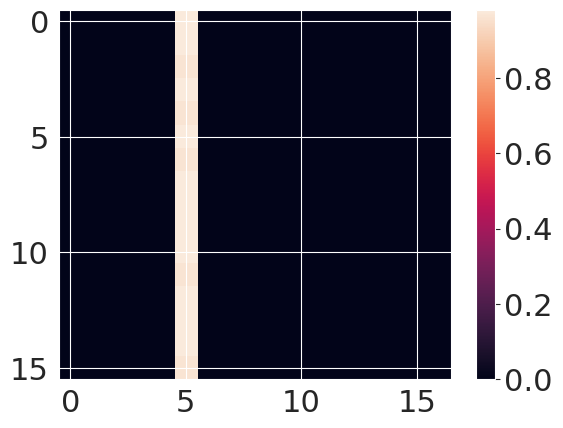

ORIGINAL LABEL: 1 COORDINATES [ 15.255041 -70.94838 ]


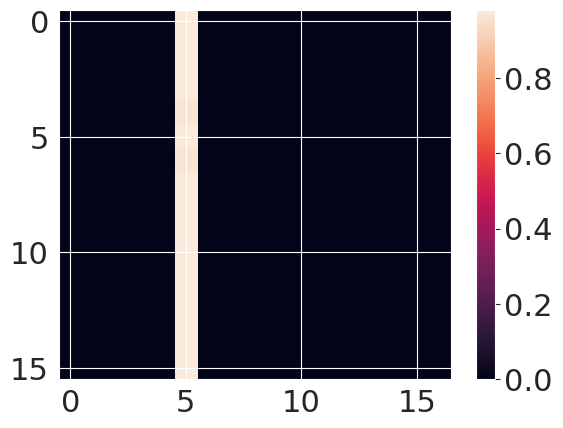

ORIGINAL LABEL: 0 COORDINATES [ 44.724033 -55.09954 ]


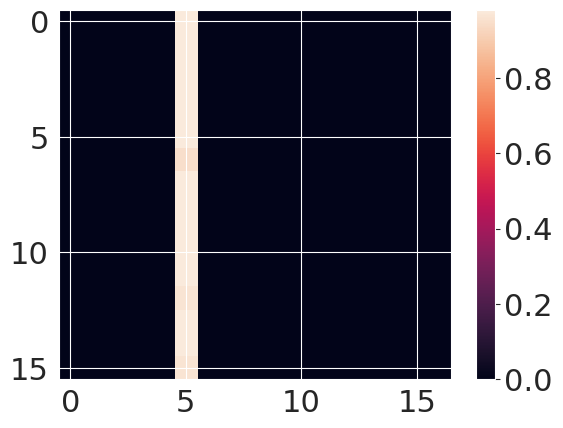

ORIGINAL LABEL: 1 COORDINATES [ 31.870893 -57.217926 ]


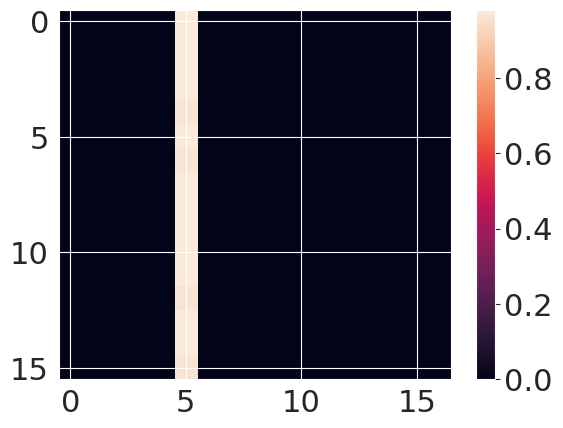

ORIGINAL LABEL: 1 COORDINATES [ 10.642693 -87.65169 ]


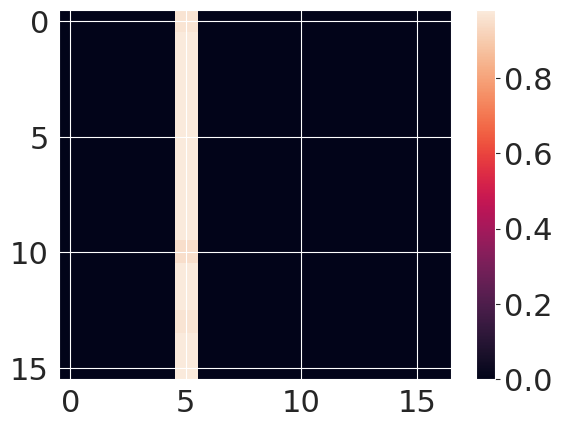

ORIGINAL LABEL: 2 COORDINATES [ 23.434042 -93.46841 ]


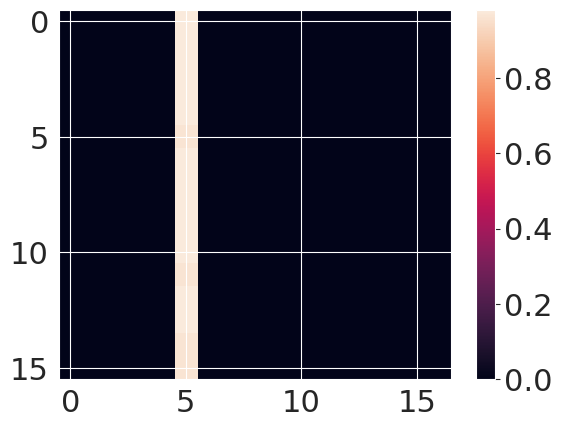

ORIGINAL LABEL: 1 COORDINATES [ 33.187416 -76.77728 ]


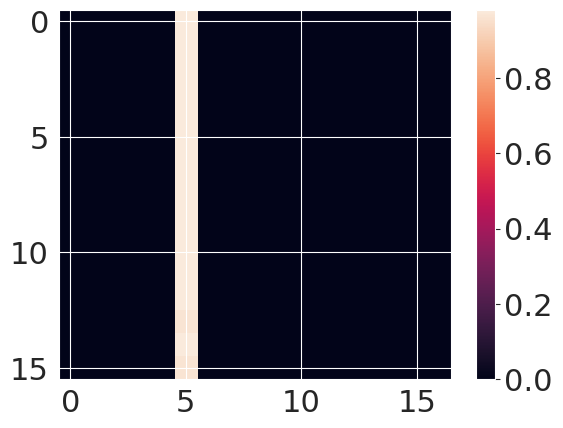

ORIGINAL LABEL: 1 COORDINATES [ 24.680021 -74.558136 ]


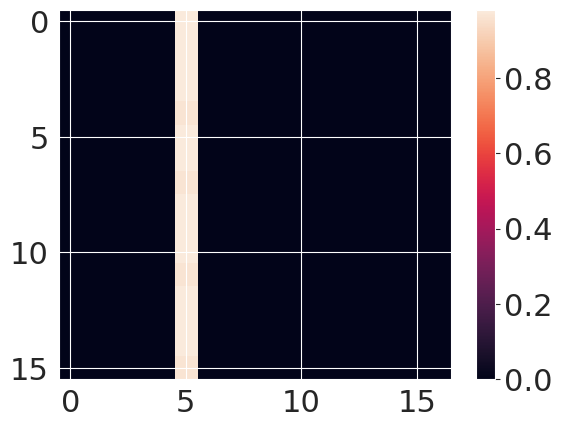

ORIGINAL LABEL: 1 COORDINATES [ 26.857964 -76.912186 ]


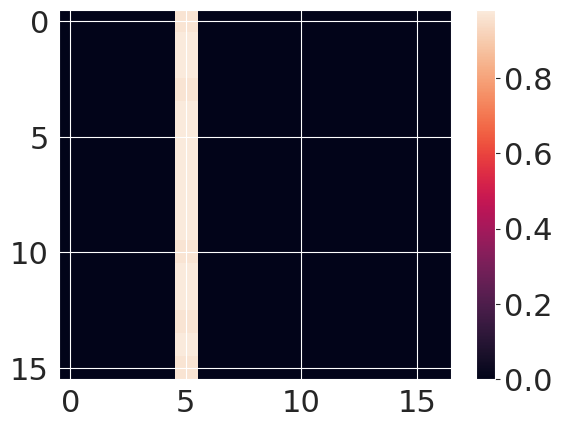

ORIGINAL LABEL: 1 COORDINATES [ 20.36914 -99.21881 ]


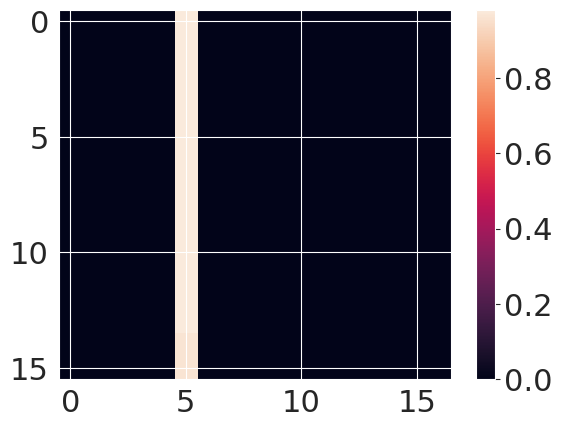

ORIGINAL LABEL: 0 COORDINATES [ 33.859047 -65.11142 ]


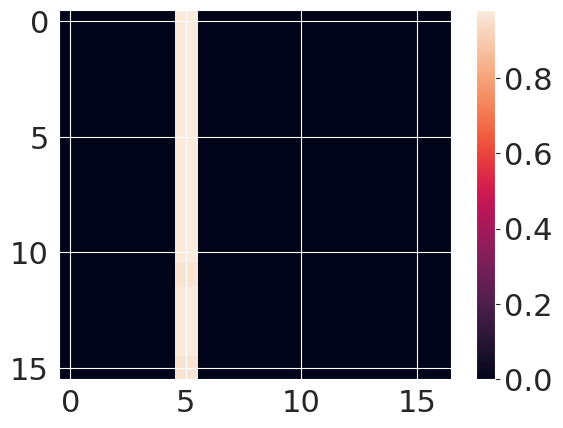

ORIGINAL LABEL: 0 COORDINATES [ 27.279327 -59.036034 ]


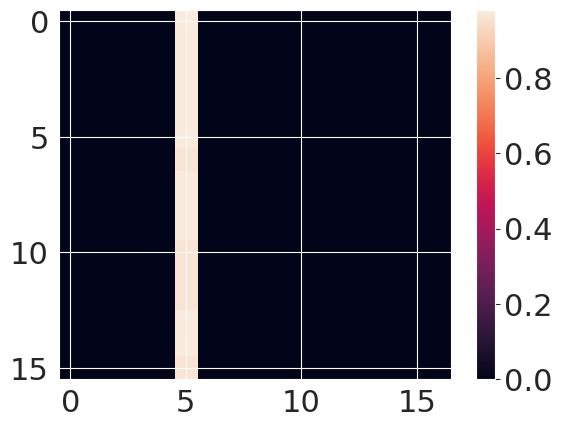

ORIGINAL LABEL: 2 COORDINATES [ 2.5469997 -90.63356 ]


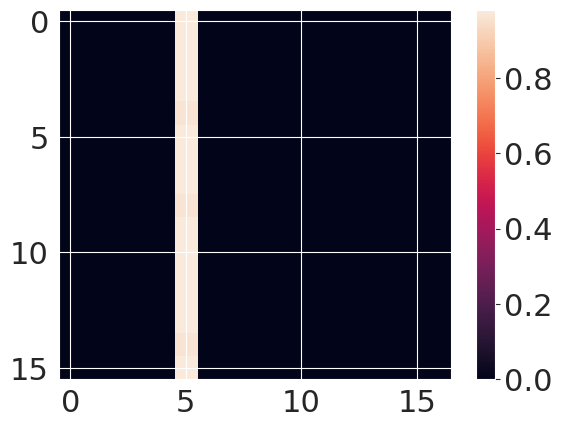

ORIGINAL LABEL: 0 COORDINATES [ 12.919721 -87.519394 ]


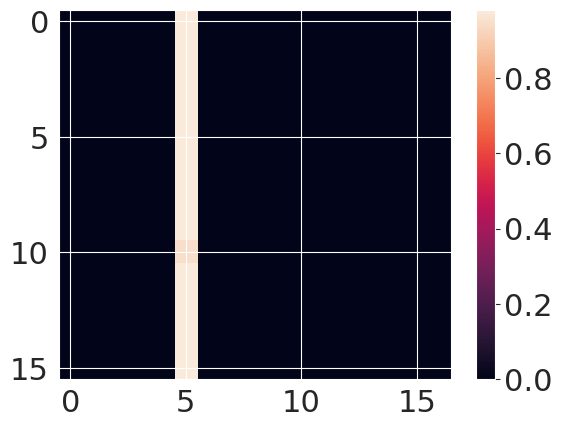

ORIGINAL LABEL: 1 COORDINATES [ 15.33914 -50.199085 ]


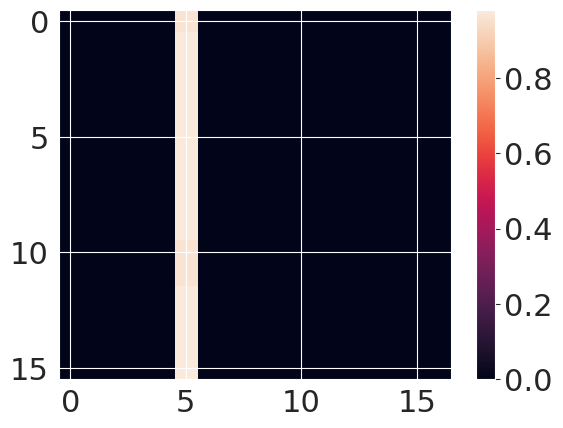

ORIGINAL LABEL: 1 COORDINATES [ 25.385477 -53.518482 ]


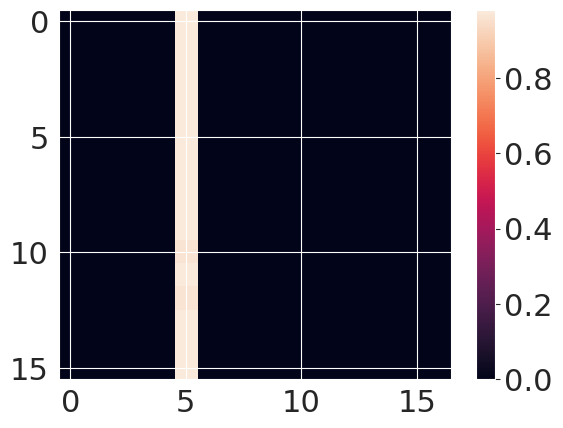

ORIGINAL LABEL: 1 COORDINATES [ 7.0172143 -84.64127 ]


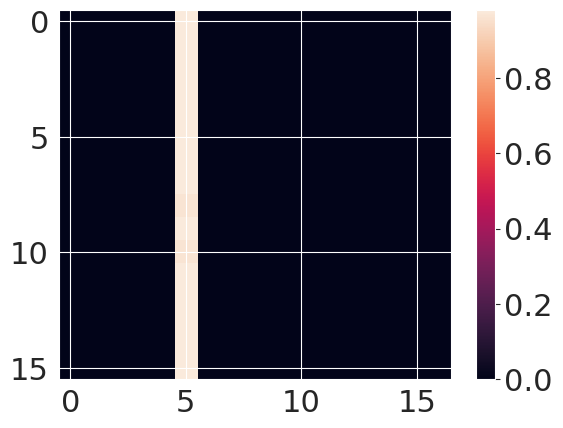

ORIGINAL LABEL: 0 COORDINATES [ 11.080075 -50.534588 ]


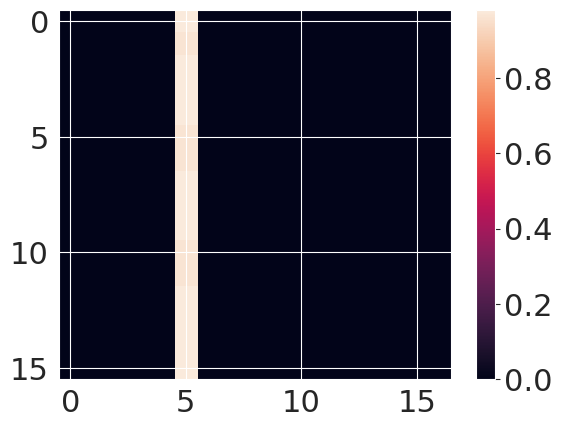

ORIGINAL LABEL: 1 COORDINATES [ 4.5453367 -74.440956 ]


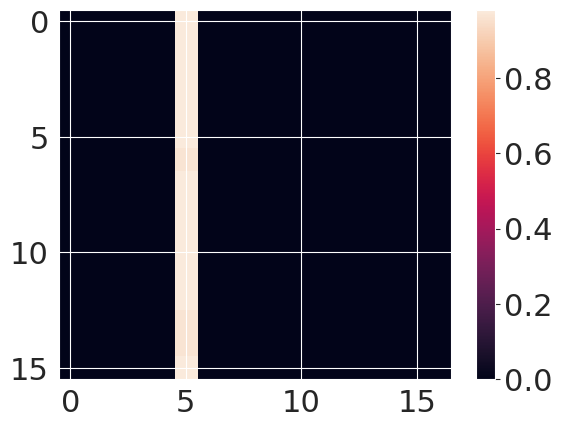

ORIGINAL LABEL: 0 COORDINATES [ 49.242184 -68.84875 ]


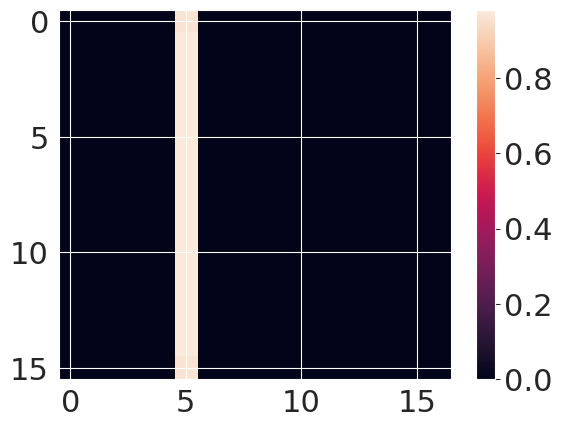

ORIGINAL LABEL: 2 COORDINATES [ 17.241955 -61.353367 ]


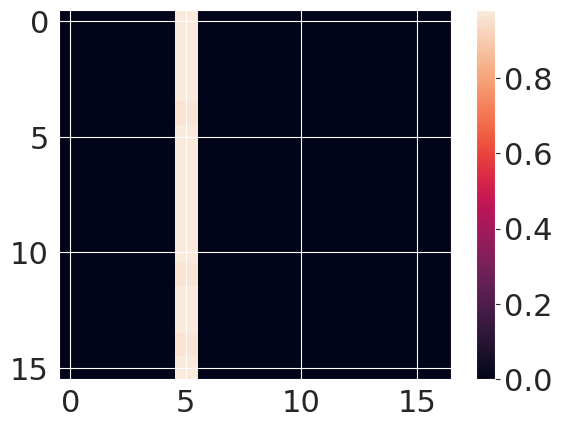

ORIGINAL LABEL: 1 COORDINATES [ 48.867676 -72.26886 ]


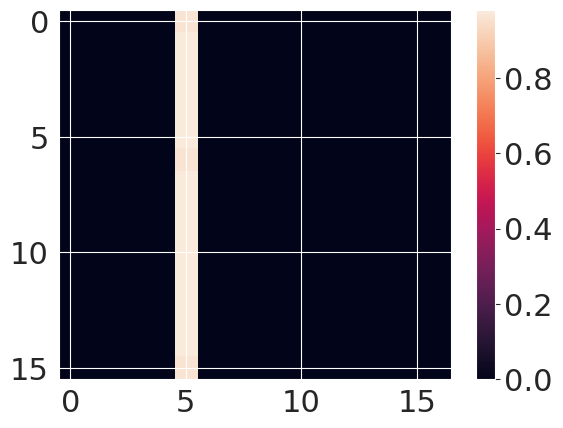

ORIGINAL LABEL: 2 COORDINATES [ 47.34674 -75.807526 ]


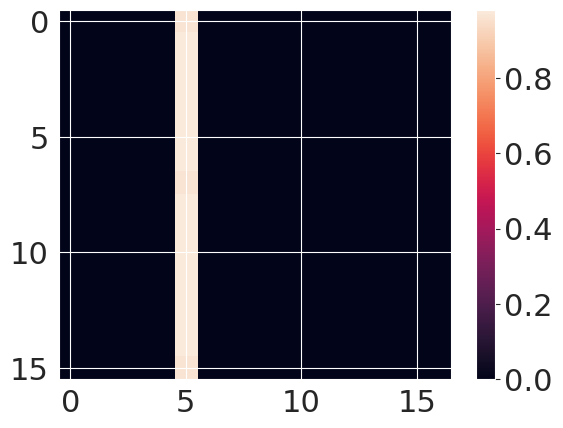

ORIGINAL LABEL: 2 COORDINATES [ 36.191116 -75.09524 ]


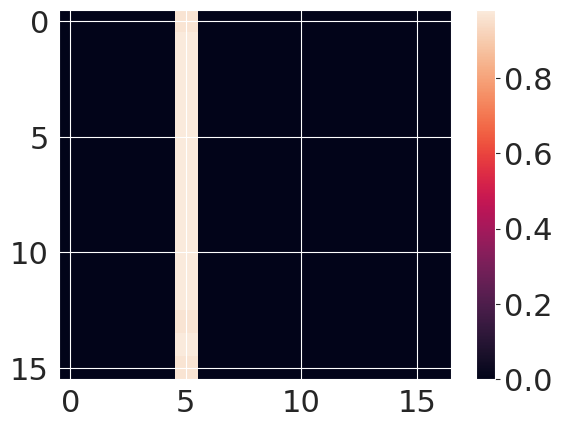

ORIGINAL LABEL: 1 COORDINATES [ 31.135885 -66.82872 ]


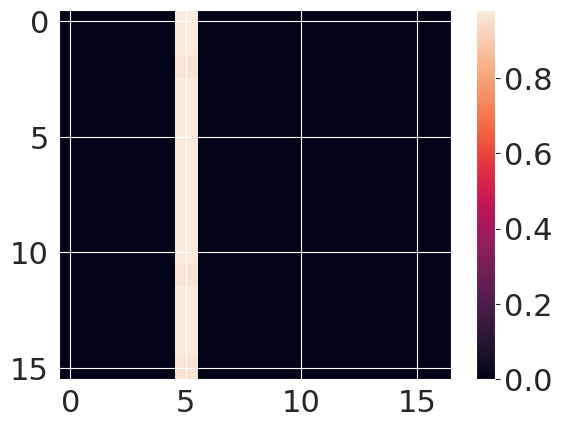

ORIGINAL LABEL: 1 COORDINATES [ 9.124775 -77.08904 ]


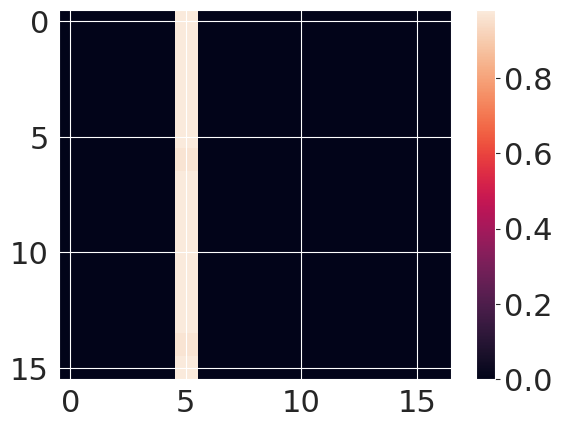

ORIGINAL LABEL: 1 COORDINATES [ 33.50537 -60.76204 ]


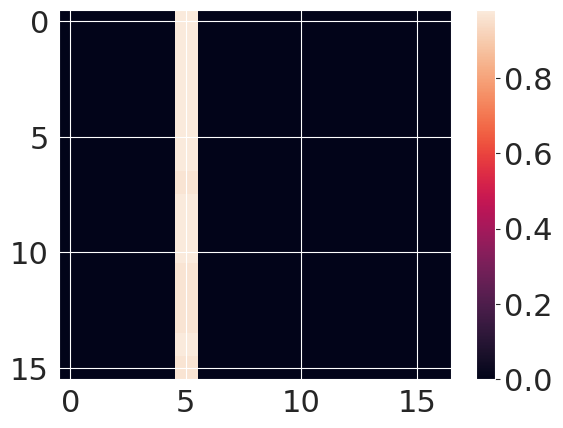

ORIGINAL LABEL: 0 COORDINATES [ 27.62535 -65.83739 ]


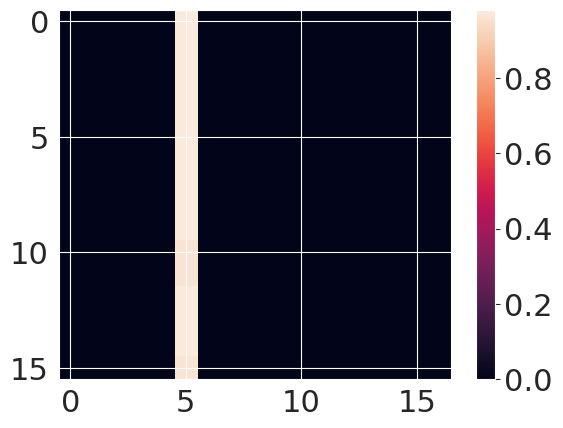

ORIGINAL LABEL: 0 COORDINATES [ 15.039516 -63.555138 ]


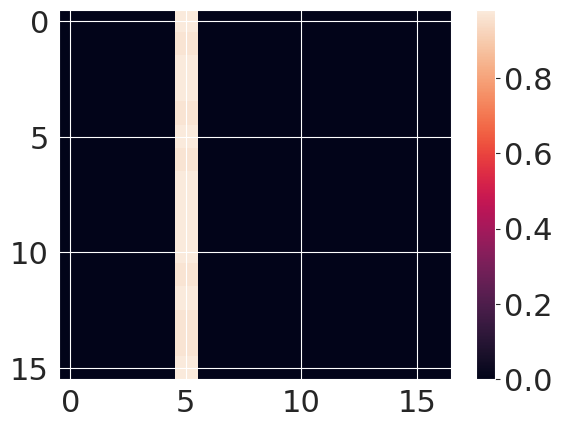

In [36]:
condition_dim1 = np.logical_and(50 > tsne_results[:,0], tsne_results[:,0] > 0)  # dimension X
condition_dim2 = np.logical_and(-50 > tsne_results[:,1], tsne_results[:,1] > -100)  # dimension Y
combined_condition = np.logical_and(condition_dim1, condition_dim2)
indexes = np.where(combined_condition)[0]

for c_ix in np.random.choice(indexes, size=[30,]):  # pick random 30
    if df_classes_r[c_ix] == 3 and df_classes_nr[c_ix] != 3:
        print("ORIGINAL LABEL:", df_classes_nr[c_ix], "COORDINATES [", tsne_results[c_ix,0], tsne_results[c_ix,1], "]")
        matplotlib.pyplot.imshow(df_subset_og_shape[c_ix])
        matplotlib.pyplot.colorbar()
        matplotlib.pyplot.show()
     

Now instead we take a look at the original CTRL samples included in the dataset (i.e. *before* relabeling) that lie closer to the rest of the dataset samples, i.e. with coordinates $x < 30$ and $y < 0$. From such plots we note how CTRL samples do not in fact always present the same pattern, but rather show other activity going on in other KPIs that are usually pretty flat while traffic is idle. This highlights, despite the large number of samples relabeled, how conservative our relabeling mechanism is and that we should investigate better ways to capture also these more subtle CTRL traffic instances (note that CTRL traffic is collected by simply associating the UE to gNB but without running any particular traffic). 

In [14]:
ctrl_before_relabel_ixs = np.where(np.array(df_classes_nr) == 3)[0]

ORIGINAL LABEL: 3 COORDINATES [ 32.569122 78.43842 ]


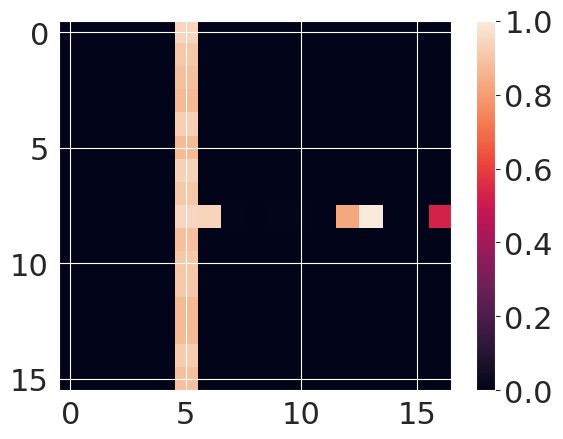

ORIGINAL LABEL: 3 COORDINATES [ 51.85633 53.689747 ]


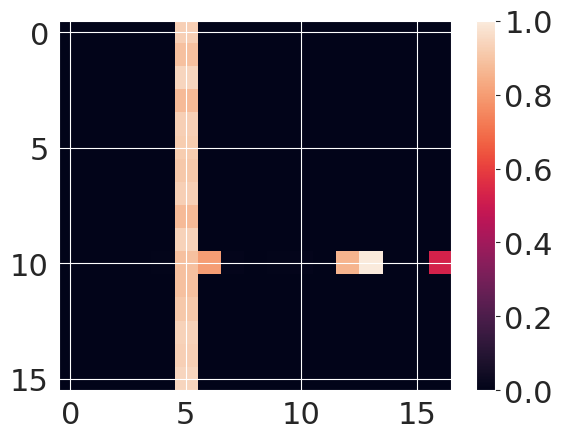

ORIGINAL LABEL: 3 COORDINATES [ 62.94175 29.649221 ]


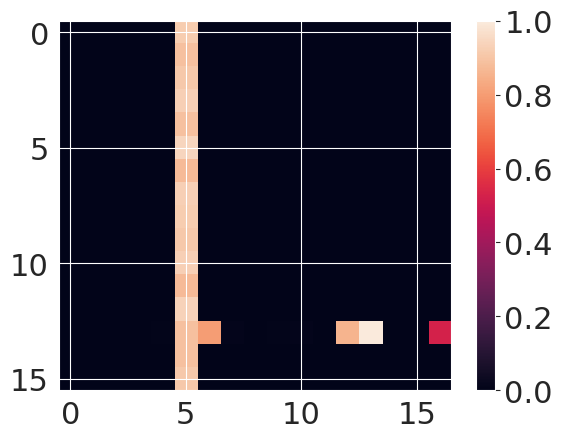

ORIGINAL LABEL: 3 COORDINATES [ 32.54289 49.537052 ]


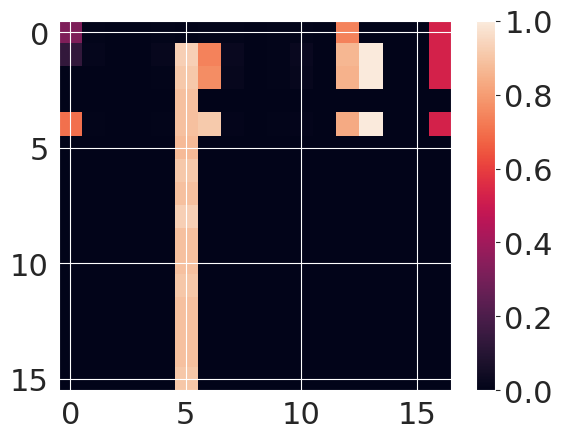

ORIGINAL LABEL: 3 COORDINATES [ 28.854206 91.70401 ]


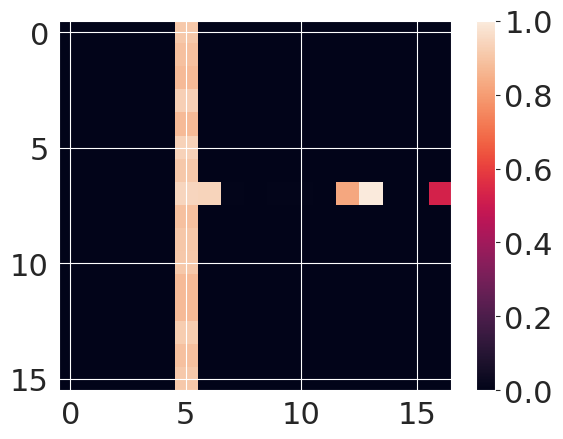

ORIGINAL LABEL: 3 COORDINATES [ 90.92295 51.835724 ]


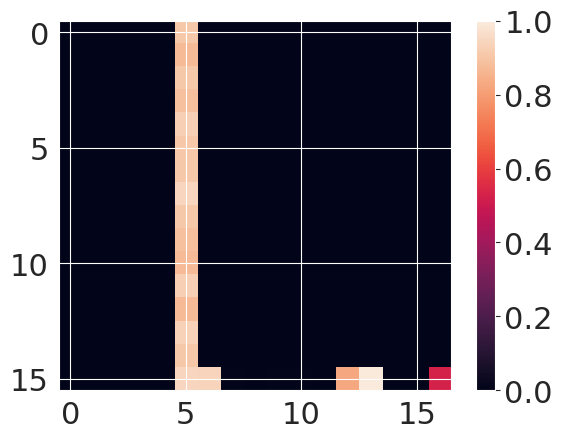

ORIGINAL LABEL: 3 COORDINATES [ 73.44028 65.50659 ]


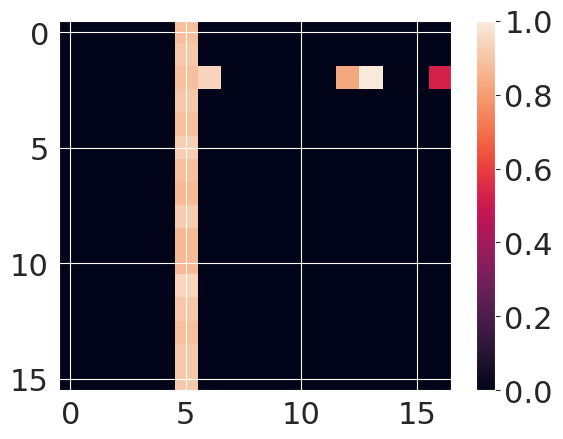

ORIGINAL LABEL: 3 COORDINATES [ 11.973044 94.14044 ]


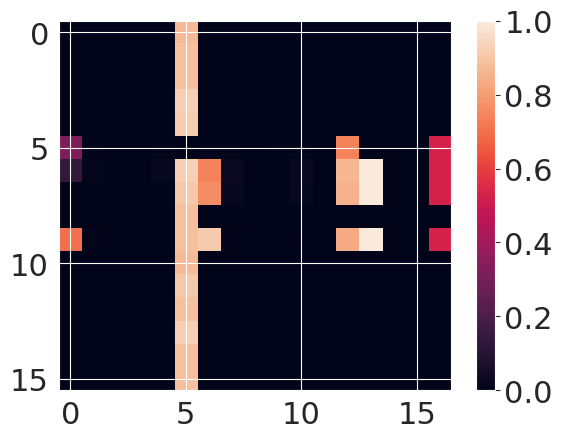

ORIGINAL LABEL: 3 COORDINATES [ 0.37585685 102.0359 ]


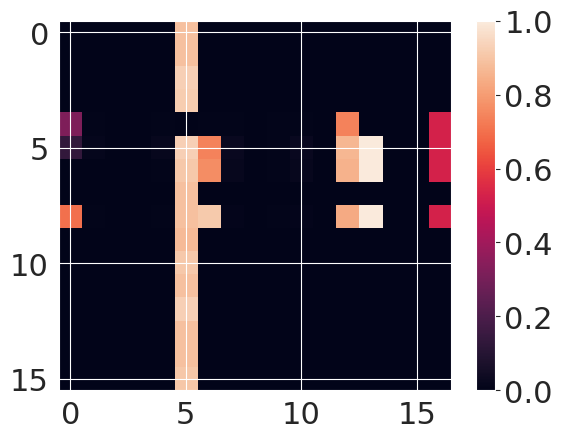

ORIGINAL LABEL: 3 COORDINATES [ 57.770226 98.03623 ]


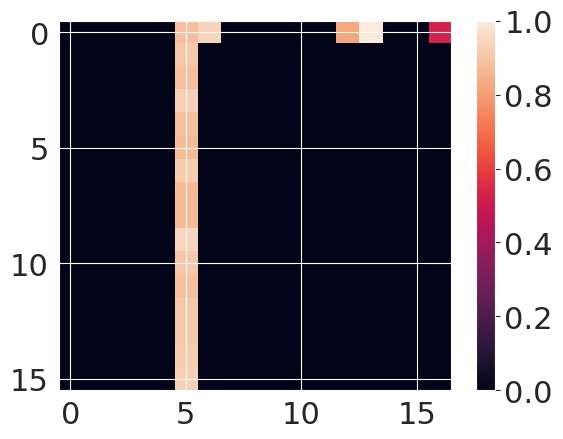

ORIGINAL LABEL: 3 COORDINATES [ 61.640575 87.4968 ]


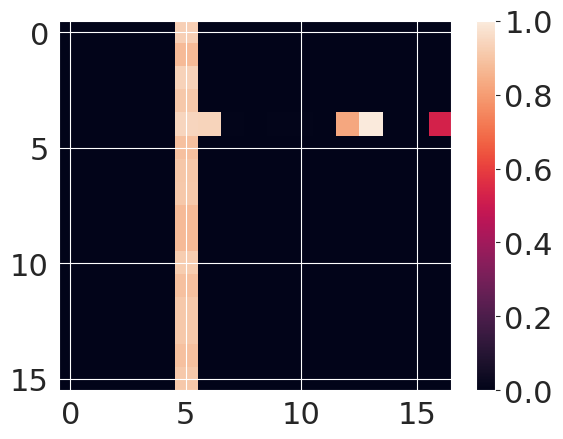

ORIGINAL LABEL: 3 COORDINATES [ 73.31808 65.45571 ]


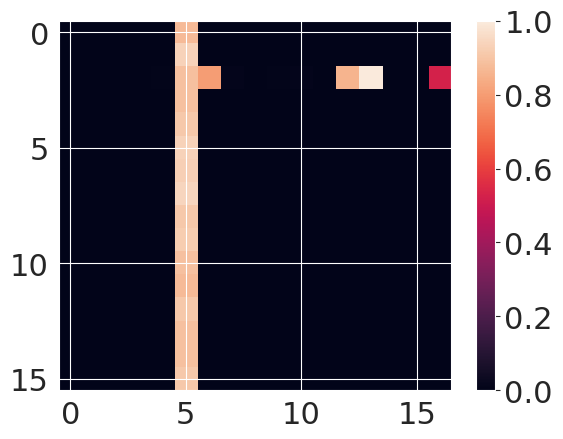

ORIGINAL LABEL: 3 COORDINATES [ 66.6105 40.135323 ]


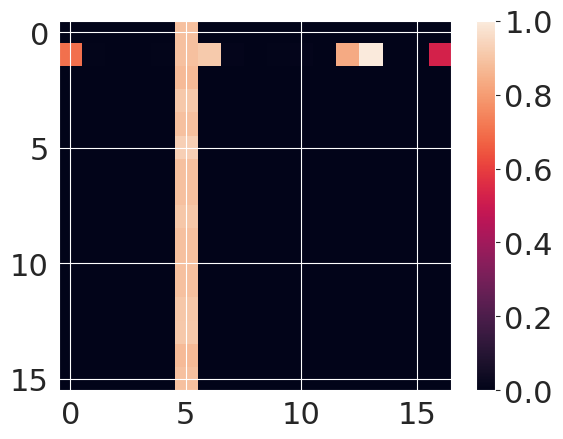

ORIGINAL LABEL: 3 COORDINATES [ 74.05385 35.646954 ]


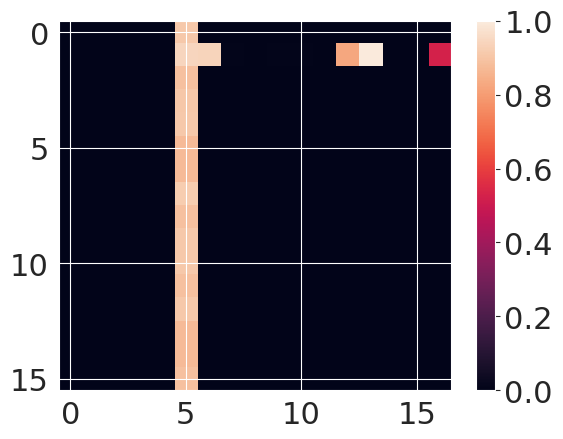

ORIGINAL LABEL: 3 COORDINATES [ 56.642357 41.909405 ]


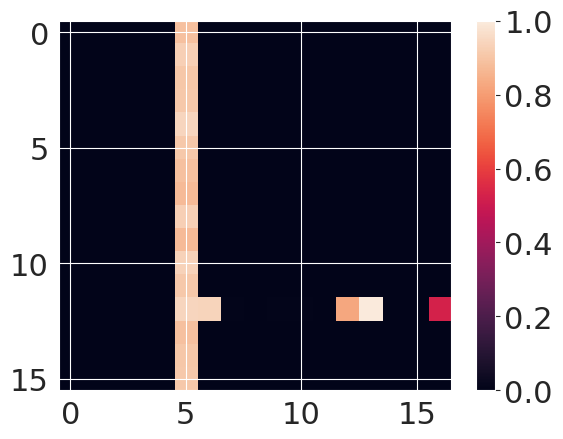

ORIGINAL LABEL: 3 COORDINATES [ 36.292725 39.293705 ]


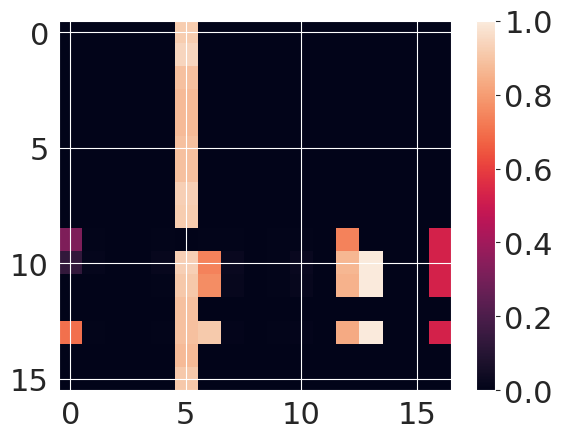

ORIGINAL LABEL: 3 COORDINATES [ 61.62742 87.50531 ]


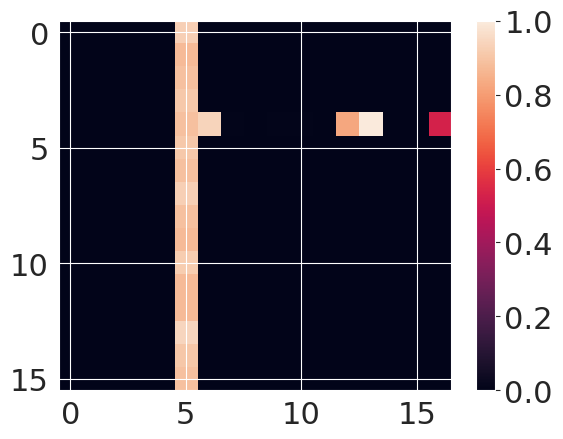

ORIGINAL LABEL: 3 COORDINATES [ 32.3315 78.25934 ]


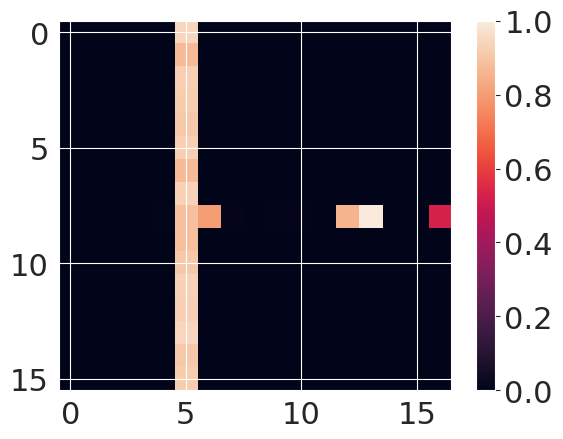

ORIGINAL LABEL: 3 COORDINATES [ 61.494404 87.44688 ]


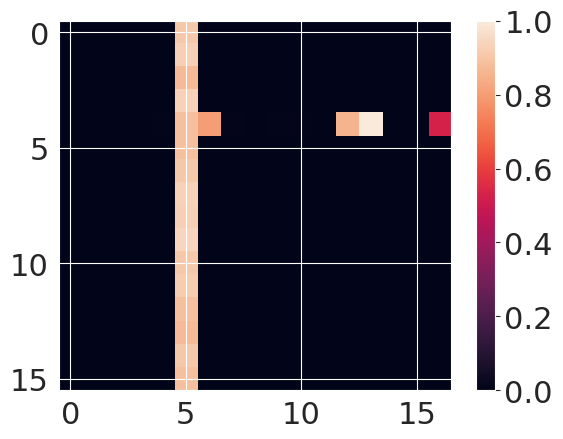

ORIGINAL LABEL: 3 COORDINATES [ 20.716566 49.20062 ]


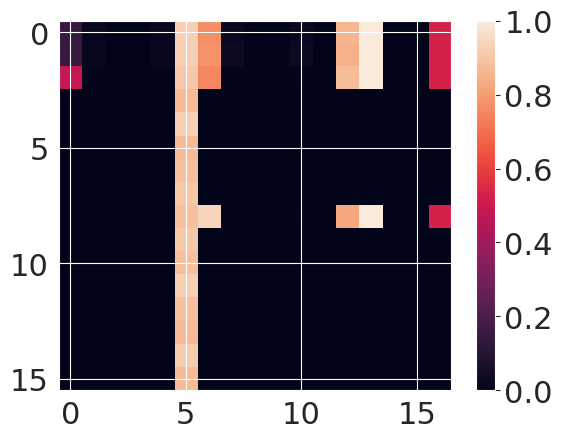

ORIGINAL LABEL: 3 COORDINATES [ 63.07348 29.918844 ]


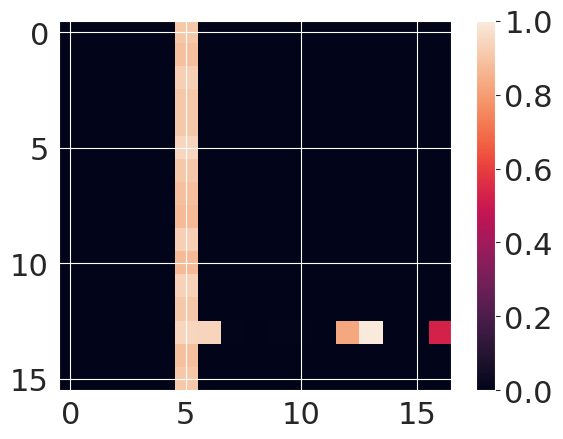

ORIGINAL LABEL: 3 COORDINATES [ 31.583057 55.414593 ]


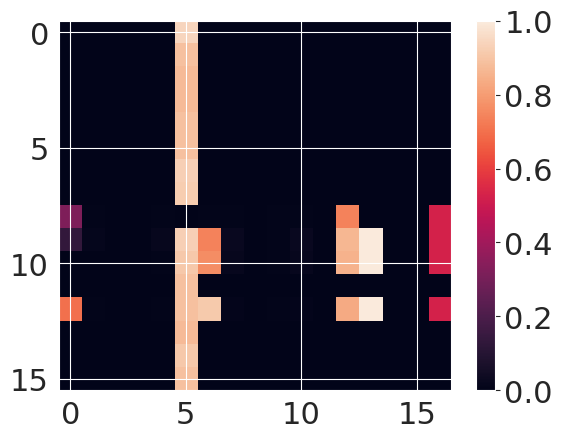

ORIGINAL LABEL: 3 COORDINATES [ 74.04961 35.64171 ]


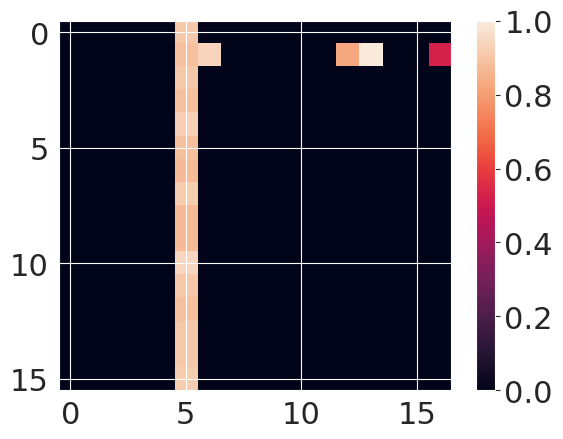

ORIGINAL LABEL: 3 COORDINATES [ 67.78374 51.055397 ]


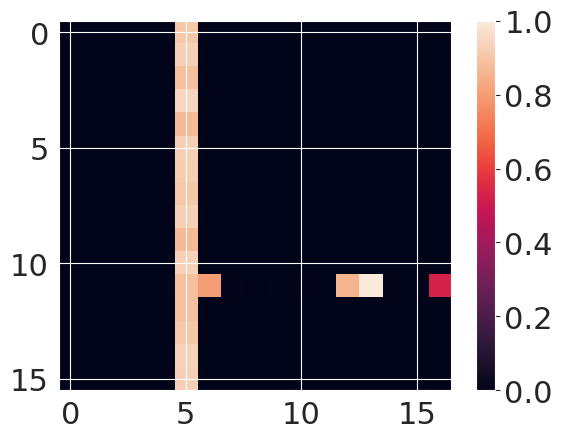

ORIGINAL LABEL: 3 COORDINATES [ 16.441563 106.84198 ]


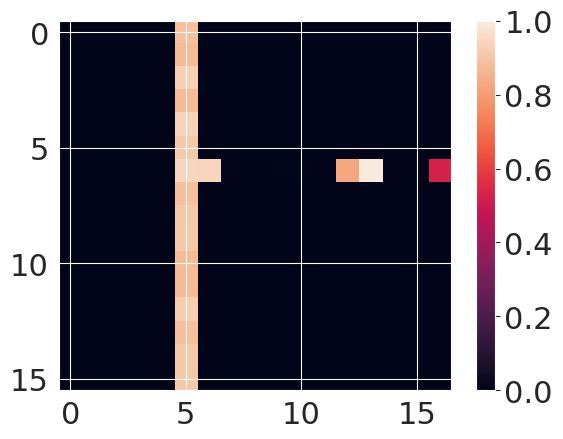

ORIGINAL LABEL: 3 COORDINATES [ 73.44497 65.50605 ]


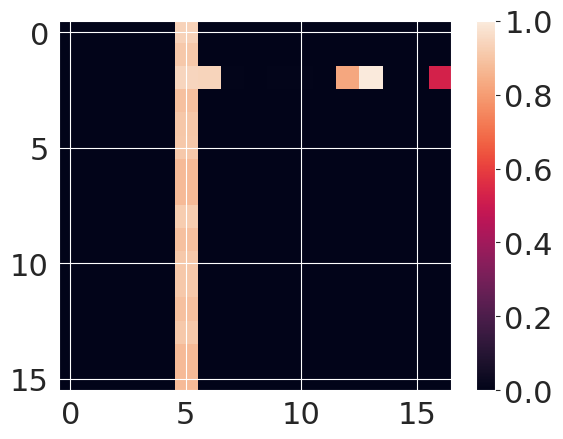

ORIGINAL LABEL: 3 COORDINATES [ 22.005611 26.90398 ]


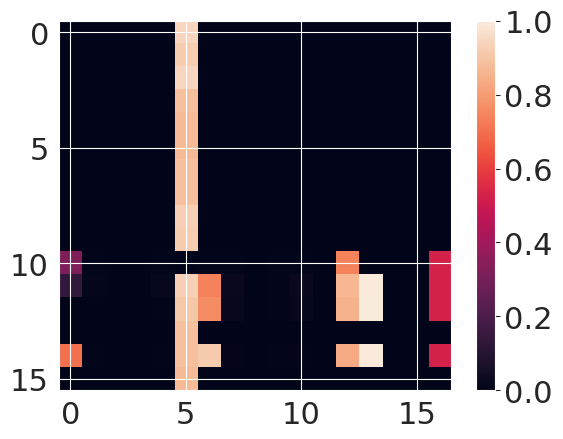

ORIGINAL LABEL: 3 COORDINATES [ 73.80214 75.60642 ]


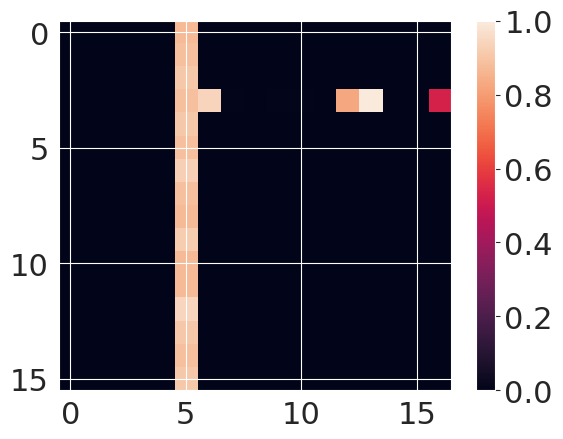

ORIGINAL LABEL: 3 COORDINATES [ 57.73836 97.905624 ]


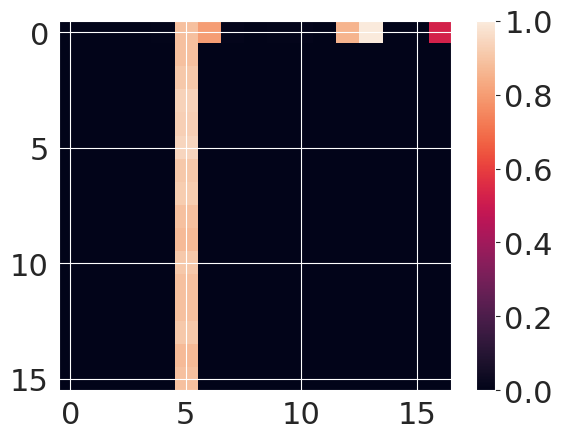

ORIGINAL LABEL: 3 COORDINATES [ 20.31359 62.816128 ]


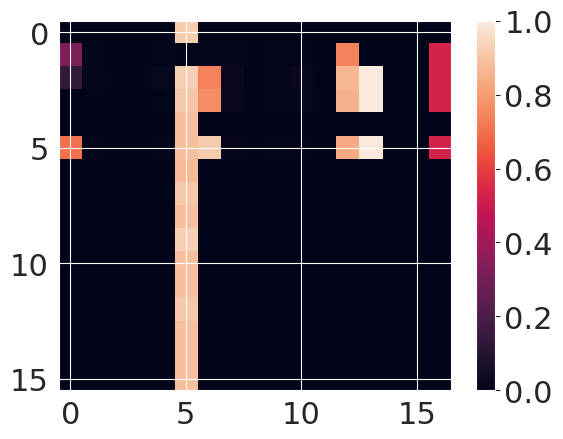

ORIGINAL LABEL: 3 COORDINATES [ 49.686478 80.284966 ]


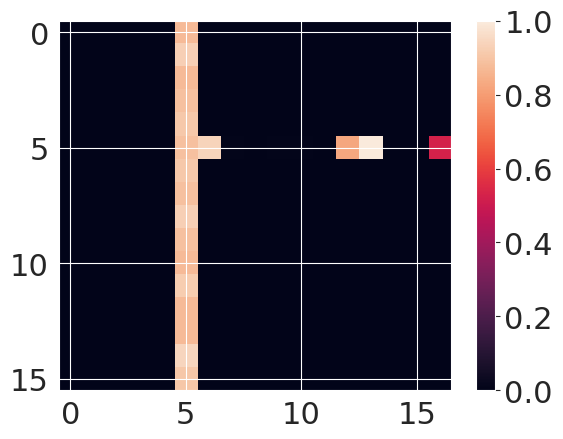

ORIGINAL LABEL: 3 COORDINATES [ 67.62083 50.770943 ]


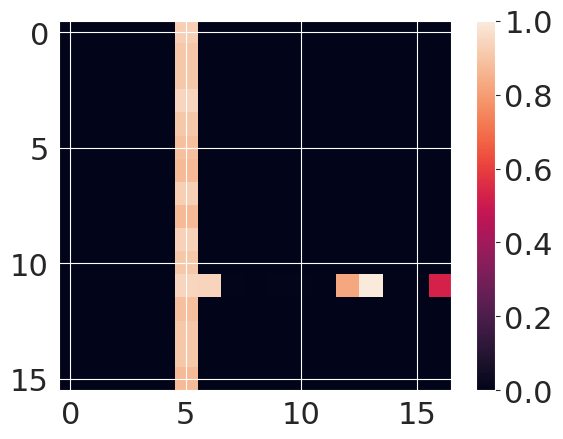

ORIGINAL LABEL: 3 COORDINATES [ 37.77135 31.806334 ]


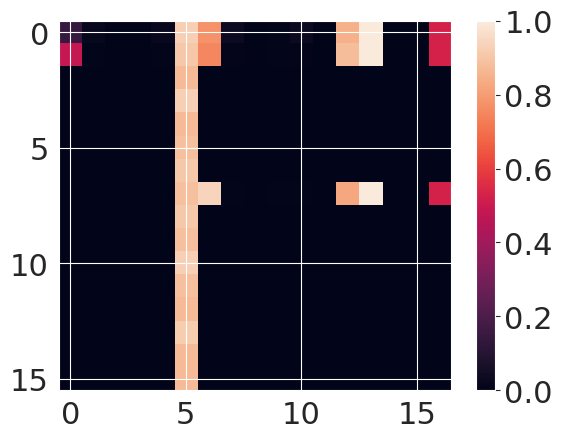

ORIGINAL LABEL: 3 COORDINATES [ 41.77589 89.35759 ]


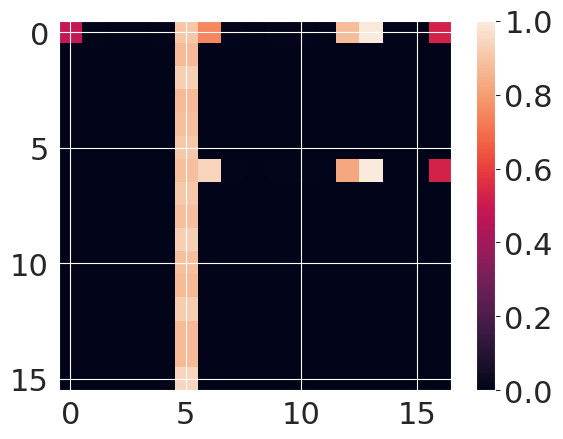

ORIGINAL LABEL: 3 COORDINATES [ 52.00602 53.85157 ]


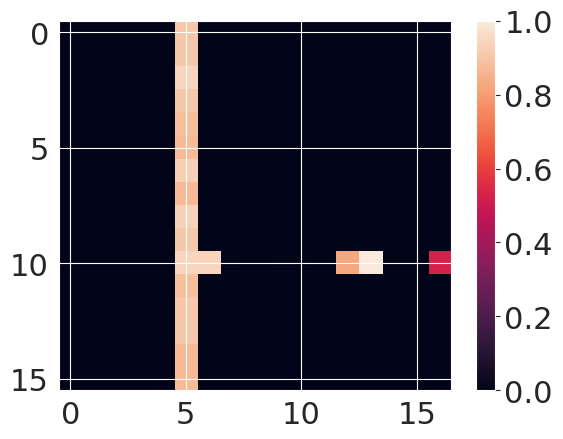

ORIGINAL LABEL: 3 COORDINATES [ 56.725082 21.28863 ]


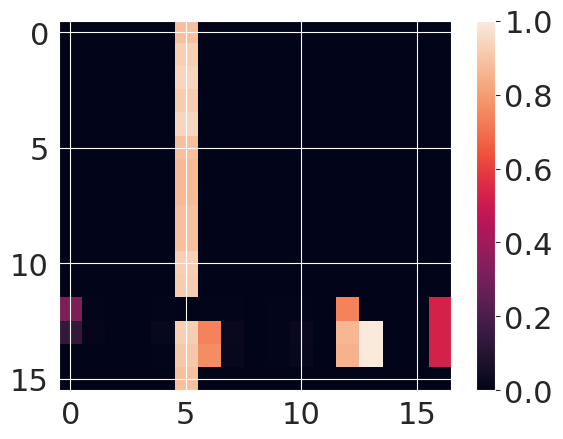

ORIGINAL LABEL: 3 COORDINATES [ 9.009613 77.75821 ]


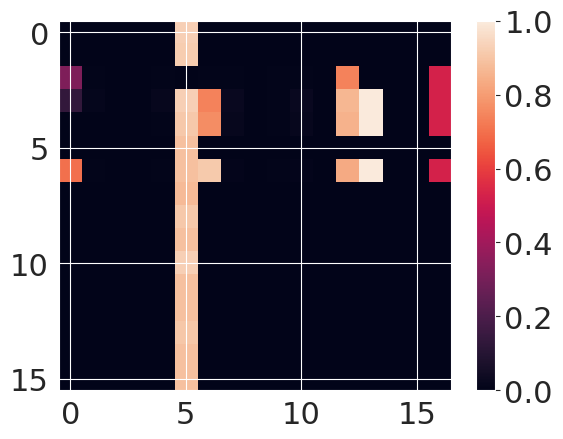

ORIGINAL LABEL: 3 COORDINATES [ 42.212307 38.335716 ]


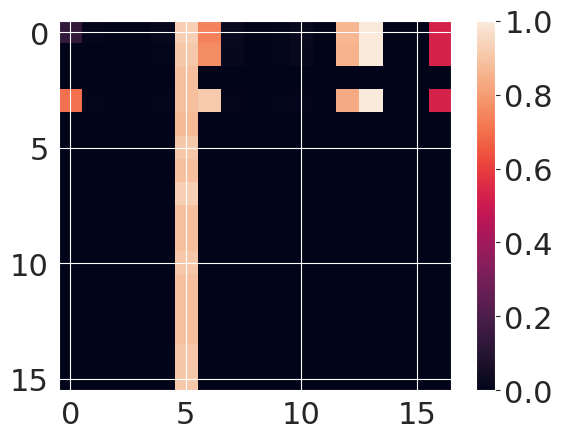

ORIGINAL LABEL: 3 COORDINATES [ 57.77204 98.02627 ]


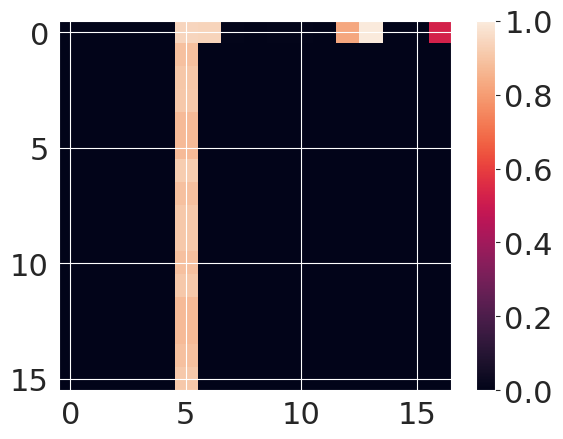

ORIGINAL LABEL: 3 COORDINATES [ 16.696505 106.73154 ]


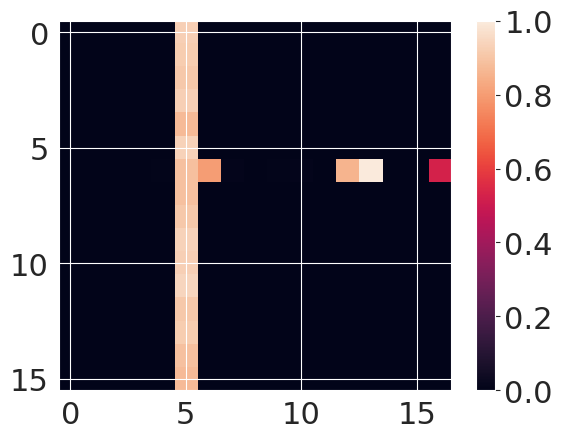

ORIGINAL LABEL: 3 COORDINATES [ 42.715683 96.569565 ]


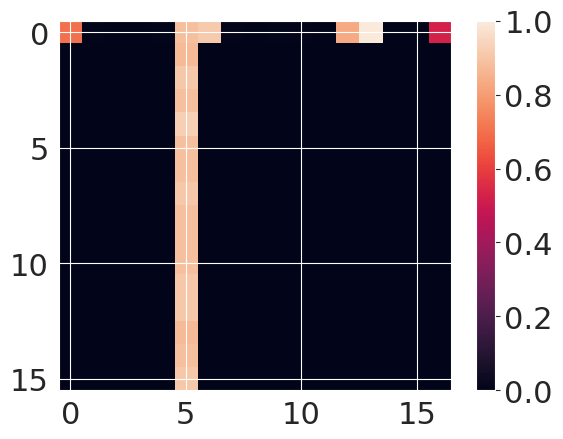

ORIGINAL LABEL: 3 COORDINATES [ 28.995998 91.52545 ]


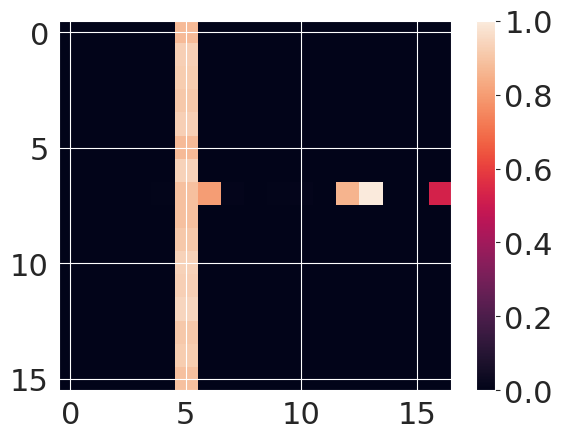

In [15]:
for c_ix in ctrl_before_relabel_ixs:
    if (tsne_results[c_ix,0] > 0) and ( tsne_results[c_ix,1] > 20):
        print("ORIGINAL LABEL:", df_classes_nr[c_ix], "COORDINATES [", tsne_results[c_ix,0], tsne_results[c_ix,1], "]")
        matplotlib.pyplot.imshow(df_subset_og_shape[c_ix])
        matplotlib.pyplot.colorbar()
        matplotlib.pyplot.show()

# T-SNE visualization with sample plot
In order to better visualize the output of T-SNE on dataset, we plot a random selection of samples, each of them centered at the relative coordinate point assigned by T-SNE in the 2d space. This help us spots the similarity in the cluster/region learned by T-SNE for a given dataset. In the code below, we first define the function to allow such alternative visualization, then we randomly sample 3000 samples from the original set and plot them on the 2d plane.

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images_with_tsne(images, tsne_coords, labels, image_scale):
    # Create a new figure
    fig, ax = plt.subplots(figsize=(15,9))
    
    # Plot the scatter plot using t-SNE coordinates
    ax.scatter(tsne_coords[:, 0], tsne_coords[:, 1], s=0, c=labels, cmap='viridis')
    
    # Set limits for the plot
    ax.set_xlim(tsne_coords[:, 0].min(), tsne_coords[:, 0].max())
    ax.set_ylim(tsne_coords[:, 1].min(), tsne_coords[:, 1].max())

    # Loop through each point and add the associated image
    for i, (image, coord) in enumerate(zip(images, tsne_coords)):
        # Get the coordinates of the point
        x, y = coord
        
        # Define the extent of the image to be plotted
        extent = [x - image_scale/2, x + image_scale/2, y - image_scale/2, y + image_scale/2]
        
        # Plot the image at the given coordinates
        ax.imshow(image, cmap='plasma', extent=extent, aspect='auto', zorder=-1)
    
    # Show the plot
    plt.show()



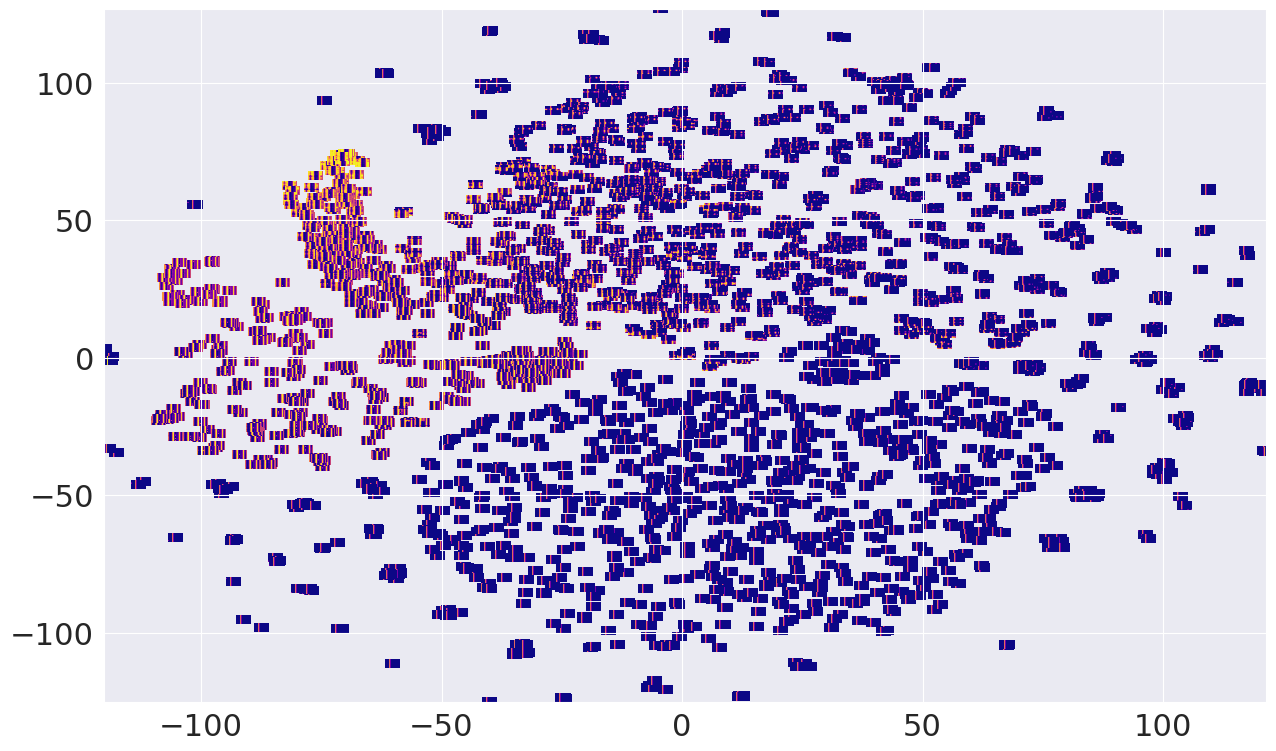

In [17]:
# Example usage
limit=3000
rand_ixs = np.random.choice(list(range(df_subset_og_shape.shape[0])), size=(limit,), )
plot_images_with_tsne(df_subset_og_shape[rand_ixs], tsne_results[rand_ixs], np.array(df_classes_nr)[rand_ixs], image_scale=3)